# Часові Ряди

Часовий ряд дає можливість передбачити значення наступної (майбутньої) точки (змінної), наприклад, передбачити ціну акції через годину, день, тиждень, базуючись на розмірності даних.

Ряд складається з двох частин - сигналу та шуму. Сигнал - це математично залежні змінні, які можна проаналізувати та прибрати з часового ряду. Шум навпаки складається з рандомних значень, частіше за все нормального розподілу, та візуально схожий на звуковий шум.

Патерни сигналу:
- Сезонність (seasonality) - циклічні коливання змінної в залежності від часу. Наприклад, зниження температури взимку. 
- Тренд (trend/level) - це наклон ряду до горизонтальної осі. Тренд може бути зростаючим або  спадаючим, якщо тренд не змінюється, то часовий ряд розташований горизонтально.
- Автокореляція - це “пам’ять” ряду, значення змінної в конкретний час напряму залежить від попередніх значень змінної.

Якщо ряд не містить патерни, його називають стаціонарним. Стаціонарним (Stationary) є ряд без тренду та сезонності, середнє та стандартне відхилення якого є константами. Окремим патерном є часові ряди, які не можна зробити стаціонарними, прибравши тренд та/або сезонність. Такі ряди називають difference - stationary. 

![timeseries](../resources/ts-1.webp)

,Unnamed: 0,Date,Sales
0,0,2021-10-01,29.109547
1,1,2021-10-02,30.720435
2,2,2021-10-03,30.305173
3,3,2021-10-04,27.390893
4,4,2021-10-05,22.841123
5,5,2021-10-06,19.002444
6,6,2021-10-07,23.904594
7,7,2021-10-08,27.544137
8,8,2021-10-09,30.567059
9,9,2021-10-10,30.087033


array([[<Axes: title={'center': 'Sales'}>]], dtype=object)

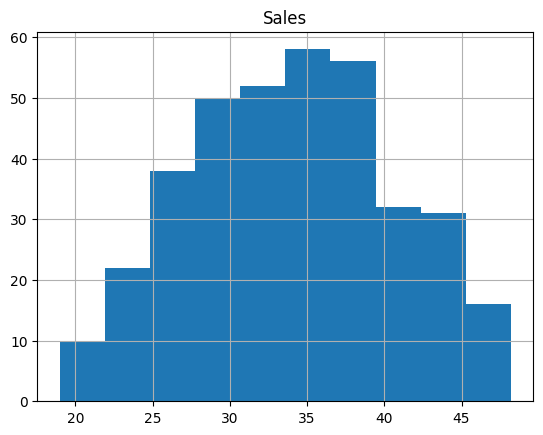

In [ ]:
import pandas as pd

data = pd.read_csv('../resources/sales.csv')
display(data.head(10))

# data = data.drop('Unnamed: 0', axis=1)
data.hist()

Зобразимо часовий ряд:

<Axes: title={'center': 'Daily Sales Over Time'}, xlabel='Date'>

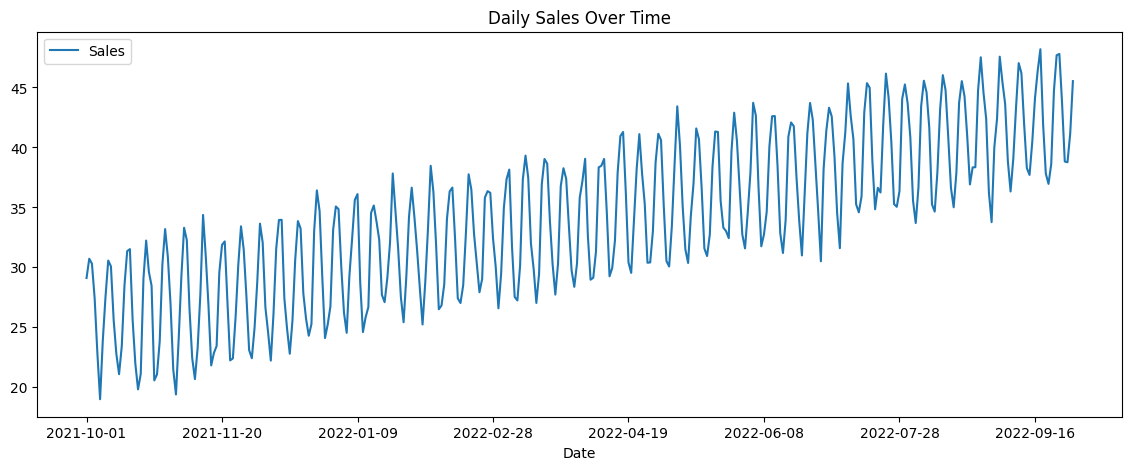

In [4]:
data.plot(x='Date', y='Sales', kind='line', title='Daily Sales Over Time', figsize=(14, 5))

In [ ]:
# data has no missing values
print(data.describe())
print("NAN values:",data.isna().sum())

            Sales
count  365.000000
mean    34.093942
std      6.572683
min     19.002444
25%     29.290376
50%     33.971567
75%     38.647294
max     48.190967
NAN values: Date     0
Sales    0
dtype: int64


На графіку вище чітко видно сезонну закономірність, яка повторюється тиждня, та висхідний тренд. Давайте детальніше розглянемо тренд та сезонну закономірність:

Шум (resid) - це часовий ряд після прибирання з нього тренду та сезонності.

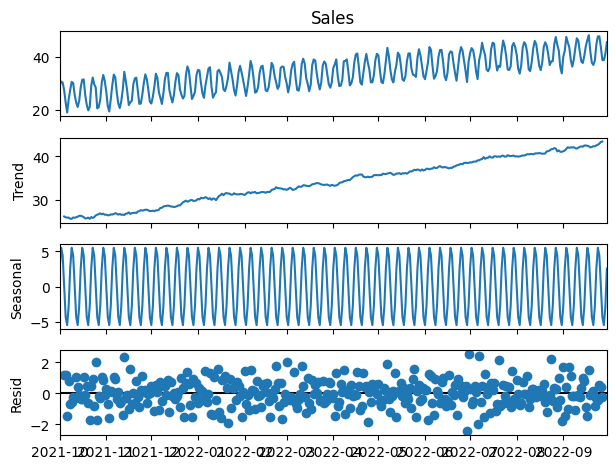

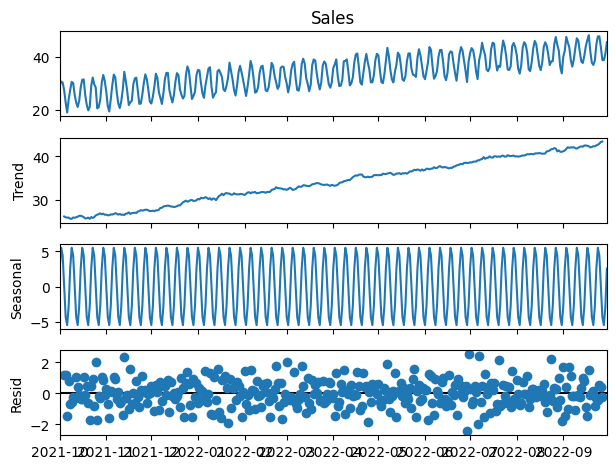

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.asfreq('D')

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data['Sales']) 
decomposed.plot()

**Доповнений тест Дікі - Фуллера (ADF)**

Тест ADF - це тест для перевірки стаціонарності часового ряду на основі unit root - це процес, який через диференціювання визначає чи є часовий ряд стаціонарним. Тест працює за принципом приймання або відкидання нульової гіпотези, яка полягає у тому, що ряд не є стаціонарним. Приймати чи відкидати нульову гіпотезу вирішується за значенням p (вірогідність неправильності нульової гіпотези): якщо значення є більшим за визначену константу, то нульова гіпотеза приймається (ряд не є стаціонарним), якщо меншим - гіпотеза відкидається (ряд є стаціонарним). Традиційно, константа = 0.05 (5%), але може бути іншою, в залежності від даних та моделі.  Також важливо дивитися і на значення статистики, якщо воно більше за будь-яке критичне значення, то часовий ряд не є стаціонарним.

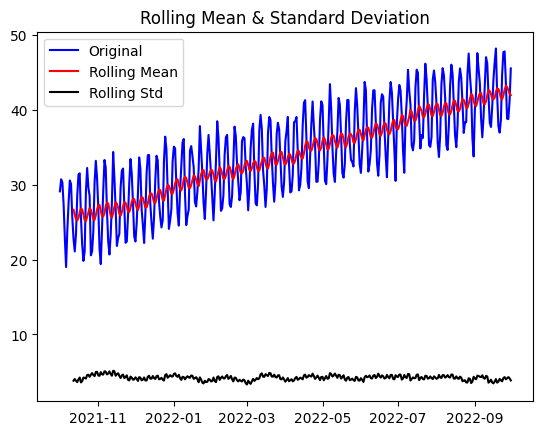

Time series is NOT stationary, p value:0.979126294138459
Statistic:0.34045531718527483
Critial Values:
   1%, -3.4492815848836296
Critial Values:
   5%, -2.8698813715275406
Critial Values:
   10%, -2.5712138845950587


In [7]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# data = data.drop('Unnamed: 0', axis=1)

def adfuller_test(df):
    adf=adfuller(df)
    statistic= adf[0]
    p_value=adf[1]
    critical_values=adf[4]
    return p_value,statistic,critical_values

def stat_check(df,p_value_check=0.05):
    movingAverage = df.rolling(window=12).mean()
    movingSTD = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    p_value,statistic,critical_values=adfuller_test(df)
    if (p_value<p_value_check):
        print('Time series is stationary, p value:{}'.format(p_value))
    else:
        print('Time series is NOT stationary, p value:{}'.format(p_value))
    print('Statistic:{}'.format(statistic))
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value}')

stat_check(data)

**Автокореляція**

Кореляція - це зв’язок змінних між собою, автокореляція - зв’язок змінної з власними попередніми значенням. Оскільки ряд має тільки одну змінну, аналізувати потрібно тільки автокореляцію. Перед тим, як графік автокореляції розкриється у всій красі, розкажу про поняття lags (лаги) - це значення змінної n - кількість часу назад, оскільки розмірністю мого часового ряду є день, то lag -1 означає значення 1 днів тому для поточної змінної, -2 -  два дні тому, тощо. На наведеному нижче графіку кількість лагів дорівнює 4.

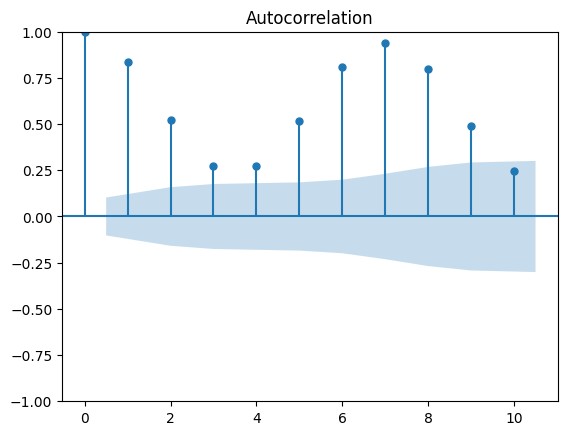

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data,lags=10)
plt.show()

Декомпозиція - це процес перетворення нестаціонарного часового ряду у стаціонарний шляхом прибирання з нього сезонності та тренду.

Реконструкція часового ряду - це процес зворотнього додавання до ряду тренду та сезонності, якщо цього не зробити, ряд буде паралельним осі х та буде мало корисним як прогнозування.

**Функції втрати**

Показниками якості моделей та прогнозування для часових рядів є функції втрати та метрики похибки. Найчастіше використовують такі функції втрати як MAE (L1 norm) - “Mean Square Error”, MSE(L2 norm) - “Mean Absolute Error”. 

MAE надає кожній помилці однакову “вагу”, тобто є робастною до викидів та шуму функцією, але одночасно з цим занижує “вплив” великих помилок.

MSE в свою чергу навпаки, дає більшим помилкам більшу вагу, що робить функцію більш чутливою до викидів. Якщо модель повинна бути чутлива до помилок, обирають саме цю функцію. 

In [10]:
import numpy as np

def calculate_mape(actual, predicted): 
  
    if([isinstance(actual, np.ndarray) or isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual),  np.array(predicted) 
    else:
        actual, predicted = np.Int(actual),  np.Int(predicted)
        
    return round(np.mean(np.abs(( 
      actual - predicted) / actual)) * 100, 2) 

**ARIMA** (AutoRegressive Integrated Moving Average) — один із найпопулярніших методів класичного прогнозування часових рядів.
Його використовують, коли дані мають автокореляцію, тренд, але не обов’язково мають сезонність.

ARIMA дозволяє моделювати складні часові залежності й робити прогноз на майбутні значення.

Модель ARIMA описується трійкою параметрів:

$$ARIMA(p, d, q)$$

де

- p – кількість авторегресивних лагів (AR)
- d – порядок диференціювання (I, Integrated), щоб зробити ряд стаціонарним
- q – порядок ковзного середнього (MA)

Поточне значення залежить від попередніх:

$$ y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t $$

Авторегресійна частина (AR(p)) - поточне значення залежить від попередніх.

Інтегрована частина (I(d)) - диференціювання робить ряд стаціонарним:

$$ y^{d}_t = y_t - y_{t-1} $$

або для d>1 – повторюється кілька разів. Стаціонарність важлива, бо AR і MA працюють саме з нею.

Ковзне середнє (MA(q))

$$ y_t = \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q} + \varepsilon_t $$

Це модель залежності від попередніх випадкових шоків (помилок).

Повна модель ARIMA - поєднання всіх частин:

$$ ARIMA(p,d,q) = AR(p) + I(d) + MA(q) $$

Після диференціювання:

$$
y'_t = \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} +
\theta_1 \varepsilon_{t-1} + ... + \theta_q \varepsilon_{t-q} + \varepsilon_t
$$

Починаємо із $y'_{0} = y_{0}$

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  365
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -536.758
Date:                Fri, 21 Nov 2025   AIC                           1103.517
Time:                        12:02:09   BIC                           1161.974
Sample:                    10-01-2021   HQIC                          1126.751
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5086      1.264     -1.193      0.233      -3.986       0.969
ar.L2         -1.0640      0.866     -1.228      0.219      -2.762       0.634
ar.L3         -0.8506      0.554     -1.536      0.1

c:\Users\vmelnyk2\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


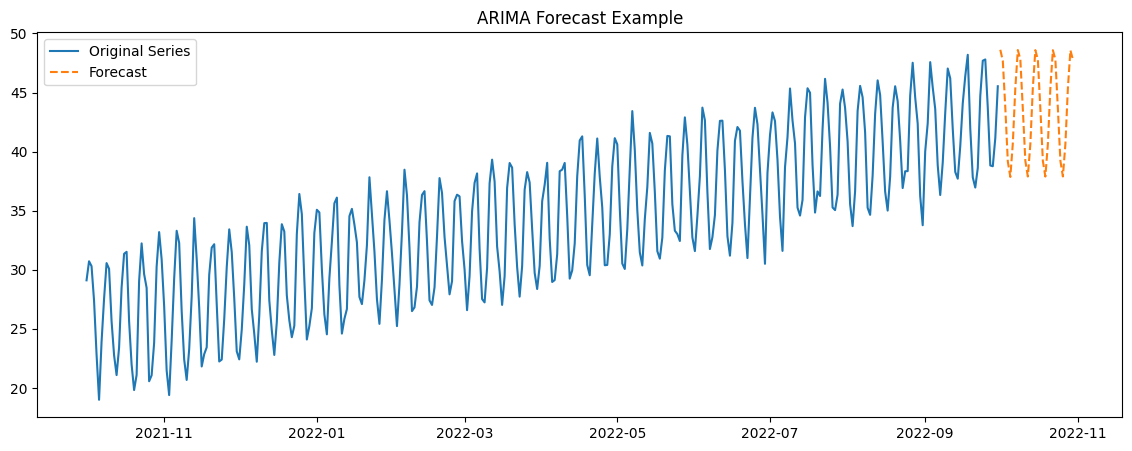

In [12]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Sales'], order=(7,1,7))
model_fit = model.fit()

print(model_fit.summary())
forecast = model_fit.forecast(steps=30)

print("Forecasted values:")
print(forecast)

plt.figure(figsize=(14, 5))
plt.plot(data['Sales'], label="Original Series")
plt.plot(forecast.index, forecast, label="Forecast", linestyle='--')
plt.legend()
plt.title("ARIMA Forecast Example")
plt.show()

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

**Передбачення із використанням методі машинного навчання.**

$y_{n} (y_{n-1}, y_{n-2}, ..., y_{n-p})$

Forecast:


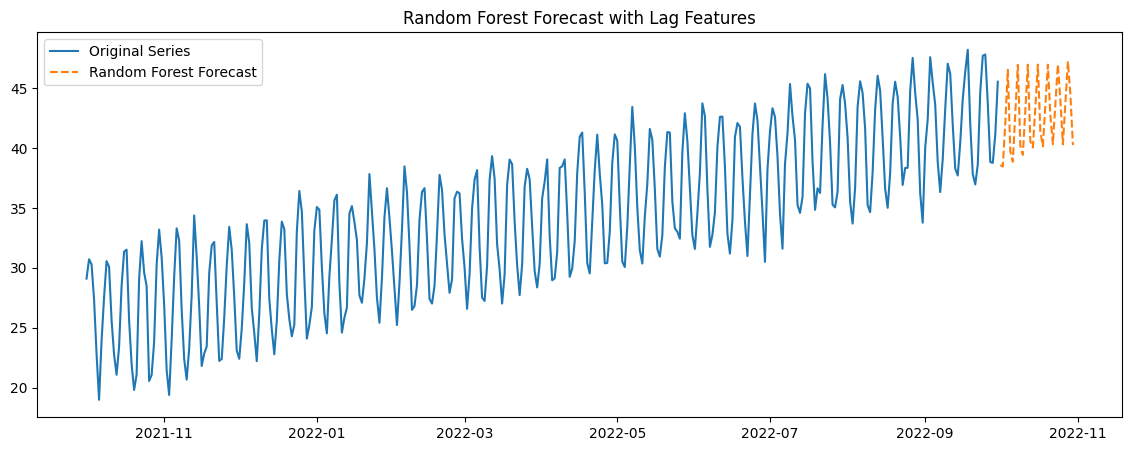

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def create_lags(series, n_lags=10):
    df = pd.DataFrame({"y": series})
    for i in range(1, n_lags + 1):
        df[f"lag_{i}"] = df["y"].shift(i)
    return df.dropna()

N_LAGS = 10
df_lags = create_lags(data['Sales'], N_LAGS)

X = df_lags.drop("y", axis=1)
y = df_lags["y"]

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)

steps = 30
last_values = list(data['Sales'].values[-N_LAGS:])
forecast_values = []

for _ in range(steps):
    x_input = np.array(last_values[-N_LAGS:]).reshape(1, -1)
    y_pred = model.predict(x_input)[0]
    
    forecast_values.append(y_pred)
    last_values.append(y_pred)

last_date = data.index[-1]
future_index = pd.date_range(start=last_date, periods=steps+1, freq='D')[1:]

forecast = pd.Series(forecast_values, index=future_index)

print("Forecast:")
plt.figure(figsize=(14, 5))
plt.plot(data['Sales'], label="Original Series")
plt.plot(forecast.index, forecast, label="Random Forest Forecast", linestyle='--')
plt.legend()
plt.title("Random Forest Forecast with Lag Features")
plt.show()


## Експоненційне зглажування

Експоненційне згладжування — це клас методів прогнозування часових рядів, у яких останні спостереження отримують більшу вагу, ніж старі.
Ваги зменшуються експоненційно, звідки й назва.

Нехай $ y_t $ — фактичне значення часового ряду,
а $ \hat{y}_{t} $ — прогноз.

Тоді *просте експоненційне згладжування (SES)* визначається як:

$$
\hat{y}_{t} = \alpha y_{t-1} + (1 - \alpha)\hat{y}_{t-1}
$$

де

- $ 0 < \alpha < 1 $ — коефіцієнт згладжування
- велике $ \alpha $ - модель сильніше реагує на нові дані
- мале $ \alpha $ - прогноз згладжений, повільно змінюється


*Модель Холта (Holt’s Linear Trend)*: якщо в ряді є тренд, ми додаємо окрему модель для тренду:

$$
\begin{aligned}
\hat{y}_{t} &= \ell_{t-1} + b_{t-1} \
\ell_t &= \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1}) \
b_t &= \beta (\ell_t - \ell_{t-1}) + (1-\beta) b_{t-1}
\end{aligned}
$$

де

- $ \ell_t $ — рівень
- $ b_t $ — тренд
- $ \alpha, \beta \in (0,1) $

Forecast:


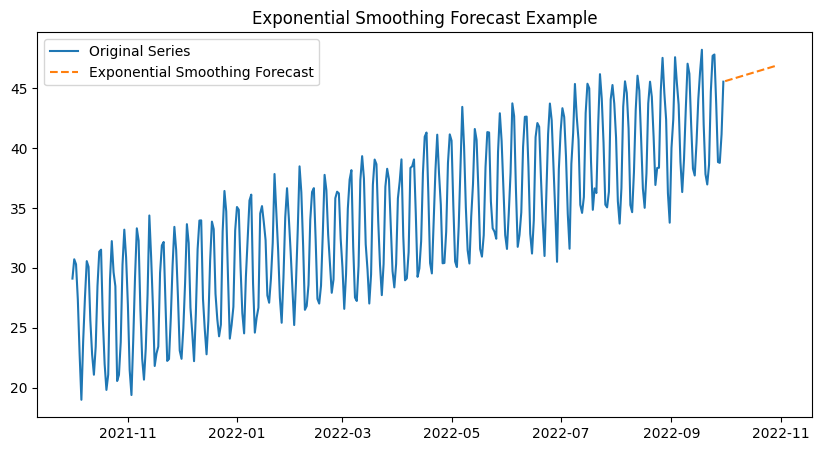

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    data['Sales'],
    trend="add",      
    seasonal=None     
)

model_fit = model.fit()
forecast = model_fit.forecast(30)

print("Forecast:")
plt.figure(figsize=(10, 5))
plt.plot(data['Sales'], label="Original Series")
plt.plot(forecast.index, forecast, label="Exponential Smoothing Forecast", linestyle="--")
plt.legend()
plt.title("Exponential Smoothing Forecast Example")
plt.show()
